# Lab 10: Unsupervised Learning
COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

This lab is due to Gradescope by the beginning of lab next week (2:45p on 4/14). You may work with a partner on this lab – if you do, submit only one solution as a “group” on Gradescope.


## Introduction

Cancer is the second leading cause of death in the United States (after heart disease), and the development of general therapeutics still poses a significant challenge for medical researchers. It has been said that cancer is a "disease of multicellularity," involving a human's own cells "going rogue" by expressing genes they shouldn't and replicating out of control. The advent of fast inexpensive DNA and RNA sequencing techniques now makes it possible for scientists to collect large-scale data about the underlying genetic causes of cancer in an effort to find effective treatments. In this lab, you will experiment with unsupervised dimensionality reduction and clustering algorithms to try to answer the following cancer research questions:

**1. Are different cancer types (e.g. lung vs. kidney) the result of the same changes in gene expression occurring in different parts of the body, or do they represent "different diseases" with mostly unique changes in gene expression?**

**2. Might it be possible to make high-confidence diagnoses of patients' cancer types from gene expression data alone?**

You will work with a RNA-Sequencing dataset from "The Cancer Genome Atlas Pan-Cancer Analysis Project" (Nature Genetics, 2013) to answer these questions. In human cells, genes encoded in DNA are translated into messenger RNA that is then transcribed into proteins. RNA-sequencing is a method for measuring which genes are currently being expressed (and to what extent). The process involves extracting messenger RNA from cell samples, sequencing the RNA, and mapping the sequences of A, U, C, and G nucleotides back to the known DNA genome. Comparing gene expression between samples from individuals with different cancer types allows researchers to test whether over- or under-expression of particular genes may be correlated with the disease. The dataset we are working with contains a random sample of gene expressions from five different types of tumor: BRCA (breast invasive carcinoma), KIRC (kidney renal clear cell carcinoma), COAD (colon adenocarcinoma), LUAD (lung adenocarcinoma), and PRAD (prostate adenocarcinoma).

You will note that the gene expression dataset *does* have ground-truth labels, even though unsupervised learning is primarily intended for data without existing labels.  However, it is common practice to use unsupervised ML with labeled data, because 1) good 2D visualizations are useful for interpreting data even if it has already been labeled, and 2) we can test whether identified clusters align with existing labels to know whether clustering future unlabeled data is likely to be effective.

## Provided Files
 * `Lab10.ipynb`: This file
 * `TCGA-PANCAN-HiSeq-801x20531.csv`: CSV file with gene expression levels of patients with one of five different cancer types
 * `TCGA-PANCAN-HiSeq-801x20531_labels.csv`: CSV file with the each patient's cancer type
 
## Part 1: Data Import and Preprocessing

The following cells import libraries and implement functions to load the dataset and create scatterplots. You do not need to modify these cells. Look up the [Matplotlib scatter() documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to understand the `plot_scatter` function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras as ks
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score

In [2]:
def load_cancer_gene_expression():
    X = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531.csv")
    y = pd.read_csv("TCGA-PANCAN-HiSeq-801x20531_labels.csv")["Class"]
    X = X.drop("Unnamed: 0", axis=1)
    y = LabelEncoder().fit_transform(y)
    return X, y


def plot_scatter(X, labels_for_coloring=None, cmap="tab10"):
    plt.scatter(x=X[:,0], y=X[:,1], c=labels_for_coloring, cmap=cmap)

## Part 2. Data Exploration

In the following cells, familiarize yourself with the cancer dataset as we have done with other datasets throughout the semester. Check the size of the examples and labels, the counts of examples from different cancer types, etc. 

In [3]:
X_cancer, y_cancer = load_cancer_gene_expression()

In [4]:
X_cancer.shape, y_cancer.shape

((801, 20531), (801,))

In [5]:
print(np.unique(y_cancer))

[0 1 2 3 4]


**Question 1:** Describe the facets of the cancer dataset you think are most important to know before beginning a ML pipeline

It is important to know that the dataset includes 801 total observation, each with 20501 features. In all, there are 5 total unique labels.

## Part 2. Dimensionality Reduction

Complete the `pca()`, `tsne()`, and `autoencode()` functions in the following cells.

  * `pca(X, n_components)`: Performs PCA on example matrix `X`, producing a new matrix with the same number of examples (rows) and `n_components` features (columns). Returns the new matrix. [Scikit-Learn PCA Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)
  
  * `tsne(X, n_components)`: Performs t-SNE on example matrix `X`, producing a new matrix with the same number of examples (rows) and `n_components` features (columns). Returns the new matrix. [Scikit-Learn t-SNE Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
 
  * `autoencode(X, n_components, hidden_layer_nodes, epochs=25)`: Creates and trains a stacked autoencoder to reduce matrix `X` to `n_components` dimensions. Returns the new matrix. `hidden_layer_nodes` should be a list with the numbers of nodes in each layer **between** the input layer and the middle encoding layer. Refer to the course textbook and/or the Keras documentation for examples. Note that you will want to be careful about your choice of activation and loss functions. 

In [6]:
def pca(X, n_components):
    pca = PCA(n_components = n_components)
    #new = pca.fit(X)
    return pca.fit_transform(X)

In [7]:
def tsne(X, n_components):
    tsne = TSNE(n_components = n_components)
    #new = TSNE.fit(X)
    return tsne.fit_transform(X)

In [8]:
def autoencode(X, n_components, hidden_layer_nodes, epochs=25):
    encoder = ks.models.Sequential()
    encoder.add(ks.Input(shape=20531))
    for i in hidden_layer_nodes:
        encoder.add(ks.layers.Dense(i, activation = 'relu'))
    encoder.add(ks.layers.Dense(n_components, activation = 'relu'))
    
    decoder = ks.models.Sequential()
    for i in reversed(hidden_layer_nodes):
        decoder.add(ks.layers.Dense(i, activation = 'relu', input_shape=[n_components]))
    decoder.add(ks.layers.Dense(20531, activation = 'relu'))
    
    autoencoder = ks.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    autoencoder.fit(x=X, y=X, epochs=epochs, validation_split = 0.15)
    return encoder.predict(X)

Use your dimensionality reduction functions to produce 2D visualizations of the cancer dataset. Create 3 plots, one each using PCA, t-SNE, and an autoencoder. Color the points in the plot according to their ground-truth label (use the `plot_scatter` function from Part 1).  Experiment with different autoencoder architectures find a network that results in a good 2D embedding.

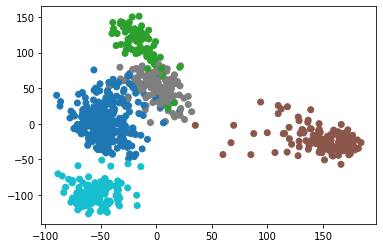

In [9]:
# Cancer Dataset: PCA

plot_scatter(pca(X_cancer, 2), y_cancer, "tab10")

/Users/rahbha/venv-COSC410/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rahbha/venv-COSC410/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


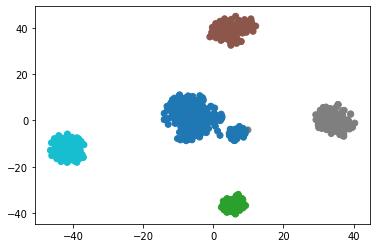

In [10]:
# Cancer dataset: t-SNE
plot_scatter(tsne(X_cancer, 2), y_cancer, "tab10")

2022-04-17 20:36:07.740722: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25
22/22 [==============================] - 2s 50ms/step - loss: 31.4115 - accuracy: 0.0324 - val_loss: 27.3447 - val_accuracy: 0.0413
Epoch 2/25
22/22 [==============================] - 1s 43ms/step - loss: 26.1716 - accuracy: 0.0074 - val_loss: 25.5468 - val_accuracy: 0.0000e+00
Epoch 3/25
22/22 [==============================] - 1s 44ms/step - loss: 25.0605 - accuracy: 0.0191 - val_loss: 24.8811 - val_accuracy: 0.0000e+00
Epoch 4/25
22/22 [==============================] - 1s 43ms/step - loss: 24.6930 - accuracy: 0.0029 - val_loss: 24.7278 - val_accuracy: 0.0661
Epoch 5/25
22/22 [==============================] - 1s 43ms/step - loss: 24.6276 - accuracy: 0.0500 - val_loss: 24.7054 - val_accuracy: 0.0661
Epoch 6/25
22/22 [==============================] - 1s 43ms/step - loss: 24.6113 - accuracy: 0.0279 - val_loss: 24.6955 - val_accuracy: 0.0661
Epoch 7/25
22/22 [==============================] - 1s 42ms/step - loss: 24.6099 - accuracy: 0.0500 - val_loss: 24.6998 - val_accuracy

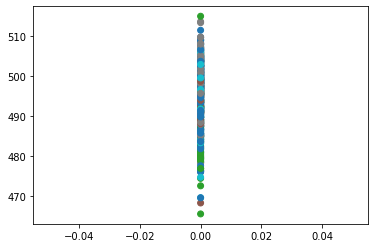

In [11]:
# Cancer dataset: Autoencoder
plot_scatter(autoencode(X_cancer, 2, [256,128,64,32] ), y_cancer, "tab10")

**Question 2**: Which dimensionality reduction technique produced the best 2D visualization of the dataset? What criteria did you use to define "best"?

So far, we thought that the t-sne produced the best 2D visiualization of the dataset. To choose which one was best, we saw which of the plots had the most separated clusters. Looking at the PCA plot, we see a lot of overlap between some clusters, especially the ones denoted in the blue, grey, and green. On the other hand, the t-sne plot has separation through all clusters it is also non-linear.

**Question 3:** What variations to the autoencoder did you try to improve the 2D representation? Which made a noticeable difference? Why might this be the case? 

We changed the number and values of hidden_layer_nodes as well as the activation function. Changing the activation function altered the plot the most (went from a dot to a line). This is because having a sigmoid activation would take out a linear relationship, which is, to some degree, what we are looking for. Sigmoid always returns a number between 0 and 1, which is not what we are looking for in this case.

## Part 3. Clustering

Complete the following function to perform clustering on an unlabeled dataset:

* `kmeans(X, n_clusters)`: Clusters `X` into `n_clusters` clusters using the k-means algorithm. Returns an integer array with the cluster indices assigned to each example in `X`. For example, if index 1 of the return value is 7, this means that example 1 (i.e. `X[1,:]`) has been assigned to cluster 7. Scikit-Learn [k-means documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#). 

In [12]:
def kmeans(X, n_clusters):
    kms = KMeans(n_clusters=n_clusters).fit_predict(X)
    return kms

In the following cell

1. Cluster the full cancer dataset (original dimensionality) into 5 clusters using `kmeans()`
2. Reduce the dataset to 2D using `tsne()`
3. Plot the 2D dataset **colored by cluster labels**

(801,)


/Users/rahbha/venv-COSC410/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rahbha/venv-COSC410/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


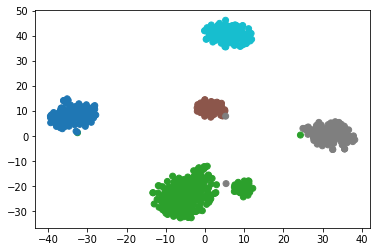

In [13]:
# Todo
k = kmeans(X_cancer, 5)
print(k.shape)
z = tsne(X_cancer, 2)
plot_scatter(z, k, "tab10")

**Question 4:** Why did we choose to find 5 clusters? 

We chose to find 5 clusters because we have 5 different labels we want to predict 

**Question 5:** How do the unsupervised k-means clusters compare to the ground truth labels? *(Visually compare against your plot from Part 2)*

It looks like it does the same other than a few outliers. Furthermore, it predicts more grey's while the others predict more blue's.

**Question 6:** What are some **pros** and **cons** of clustering a dataset in its original high dimensionality versus clustering after dimensionality reduction?

The k-means algorithm is faster, but it does not always find the absolute minima. This means that clusters centers will not be the means of the actual cluster, and this would be a con to high dimensionality. On the other hand, higher dimensionality allows us to separate based on more factors than dimensionality reduction. 

In the following cell, compute and print the [completeness score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score) to quantitatively evaluate the effectiveness of k-means clustering on the cancer dataset given the known ground-truth labels

In [14]:
print(completeness_score(y_cancer, k))

0.9763990539625917


**Question 7:** Explain this completeness score and what it means for the cancer dataset as you would to a **layperson** with no specific ML or CS knowledge.  

The completeness score tells us how accurately or how close were were able to label the dataset to perfection. For example, if we labeled all data points in the set correctly, we would see a completeness score of 1.0. In this case we see a completeness score of 0.97, which shows that we are close to perfect. The 3 outliers might be hindering this score from being 1.0.

## Part 4. Final Questions

**Question 8:** What does the data analysis in Part 2 suggest about **Research Question 1**? Support your argument by referring to your plots. What does this imply about why "curing cancer" is such a difficult medical problem?

Looking at the plots above, we see that each cluster is different and separated from another. This leads us to believe that they represent different diseases with unique changes in gene expression. This is why is it so difficult to cure cancer. Because each is unique, there is no one medicine that would cure all cancer. There would need to be unique cures for each case.  

**Question 9:** What does the data analysis in Part 3 suggest about **Research Question 2**? Support your argument by referring to your plots. 

It would be possible. Looking at our plot, we see a great amount of separation between the clusters, except for a few outliers. Additionally, our completeness score of 0.97 shows that we are nearly perfect in predicting labels. 

**Question 10:** We could have used a supervised ML approach to address **Research Question 2** given that we have ground truth labels for the cancer dataset. However, in what other real-world situations would effective clustering of unlabeled medical diagnostic results be useful for doctors?

It would be better in real-time diagonistics. For example, we can better predict grades of muscle tear based on similar plots and clusters that allow us to separate the severities. 